In [64]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

In [65]:
# CUMULATIVE DATA -> daily data
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_death_by_county.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_infection_county_cases.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

In [66]:
# # CUMULATIVE DATA -> weekly data
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weeky_death.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weekly_infection.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

In [67]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\county_size_N.xlsx")

In [68]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Gaines'

deaths = all_county_deaths.set_index('date')[county_name]
infected = all_county_infected.set_index('date')[county_name]

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
N = int(population['Population'].values[0])

# S0 = N*(exemption_val+((1-exemption_val)*(1-efficacy)))
S0 = N*(exemption_val)
R0 = 0
print(S0)

4034.245901639344


In [69]:
merged_df = pd.concat([infected.rename("Cumulative Infected"), 
                       deaths.rename("Cumulative Deaths")], axis=1)

merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})

# print(merged_df.head())
# print(merged_df.columns.tolist())

Simulation

In [70]:
H = np.array([
    [0, 0, 0, 0, 1],  # infected I
    [0, 0, 0, 1, 0],  # deaths D
], dtype=float)  

n_ens = 200
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.2

In [ ]:
I0 = int(merged_df['Cumulative Infected'].iloc[0])
D0 = int(merged_df['Cumulative Deaths'].iloc[0])
C0 = int(merged_df['Cumulative Infected'].iloc[0])

x0_mean = np.array([S0, I0, R0, D0, C0])

def R_from_obs(y_vec):
    y = np.asarray(y_vec, dtype=float)
    floors = np.array([0.005, 0.001])     # min std for C and D
    sigma  = np.maximum(0.05*np.maximum(y, 1.0), floors)
    return np.diag(sigma**2)

def sird_step_aug(state_aug, N, dt):
    S, I, R, D, C, beta, gamma, delta = state_aug
    new_infections = beta * S * I / N 
    dS = -new_infections
    dI = new_infections - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)
    C_new = C + new_infections

    beta_new = beta + np.random.normal(0, 0.0002)
    gamma_new = gamma + np.random.normal(0, 0.0002)
    delta_new = delta + np.random.normal(0, 0.0002)

    # constrain parameters to valid ranges
    beta_new = np.clip(beta_new, 0, 1)
    gamma_new = np.clip(gamma_new, 0, 1)
    delta_new = np.clip(delta_new, 0, 1)

    return np.array([S_new, I_new, R_new, D_new, C_new, beta_new, gamma_new, delta_new])


def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1:4].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:4] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

# def sird_step(state, param, N, day, dt):
#     S, I, R, D = state
#     beta, gamma, delta = param
#     dS = - beta * S * I / N
#     dI = beta * S * I / N - gamma * I - delta * I
#     dR = gamma * I
#     dD = delta * I
#     S_new = max(S + dS * dt, 0)
#     I_new = max(I + dI * dt, 0)
#     R_new = max(R + dR * dt, 0)
#     D_new = max(D + dD * dt, 0)
#     return np.array([S_new, I_new, R_new, D_new])

def predict_measurement(state_ensemble):
    C = state_ensemble[:, 4]
    D = state_ensemble[:, 3]
    return np.column_stack([C, D])

def clean_nans(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]

In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

# delta I
obs_cum = merged_df['Cumulative Infected'].to_numpy()

def run_enkf_for_seed(sim_seed):
    rng = np.random.default_rng(sim_seed)
    Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()

    def u(lo, hi, size):
        return rng.uniform(lo, hi, size)

    state_ens = np.zeros((n_ens, 8))
    
    for i in range(n_ens):
        # Perturb I, R, D
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0) 
        S = max(N - IRD.sum(), 0)
        beta = rng.uniform(0.1, 0.9)
        gamma = rng.uniform(0.1, 0.9)
        delta = rng.uniform(0.0001, 0.001)
        C = x0_mean[4]
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    n_timesteps = len(merged_df)
    ensemble_states_hist = np.full((n_timesteps, n_ens, 5), np.nan)
    ensemble_params_hist = np.full((n_timesteps, n_ens, 3), np.nan)
    
    max_passes = 10
    pass_idx = 0
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0
    
    while pass_idx < max_passes and not converged:
        pass_idx += 1
        converged_day = None

        for k in range(n_timesteps):
            total_cycles += 1

            # propogate ensembles
            C_forecast = state_ens.copy()
            for i in range(n_ens):
                state_ens[i] = sird_step_aug(state_ens[i], N, dt)
            state_ens = enforce_mass(state_ens, N)

            ensemble_states_hist[k] = state_ens[:, :5]
            ensemble_params_hist[k] = state_ens[:, 5:]

            meas_pred = predict_measurement(state_ens)  
            y_obs_k = Y_obs[k]
            Rk = R_from_obs(y_obs_k)

            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            aug_ens = np.hstack([state_ens])
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            X = aug_ens - aug_mean
            Y = meas_pred - meas_mean
            C_xy = (X.T @ Y) / (n_ens - 1)
            C_yy = (Y.T @ Y) / (n_ens - 1)

            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update
            state_ens = enforce_mass(state_ens, N)
            
            if k > 0:
                last_obs_C = Y_obs[k-1, 0]
                state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

            ensemble_states_hist[k] = state_ens[:, :5]  
            ensemble_params_hist[k] = state_ens[:, 5:]

            # to get mean of parameters across all ensembles
            
            mean_beta = np.mean(state_ens[:, 5])
            mean_gamma = np.mean(state_ens[:, 6])
            mean_delta = np.mean(state_ens[:, 7])
            print(f"Day {k}: Mean beta={mean_beta:.4f}, gamma={mean_gamma:.4f}, delta={mean_delta:.4f}")


            # Check parameter convergence (curiousity)
            if k > 0:
                prev_mean_theta = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean_theta = np.mean(state_ens[:, 5:], axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta, ord=np.inf) / (
                    np.linalg.norm(prev_mean_theta) + 1e-9
                )
                if rel_change < tol:
                    converg_counter += 1
                    if converg_counter >= 1:
                        converged_day = k
                else:
                    converg_counter = 0

        last_day = converged_day if converged_day is not None else n_timesteps - 1
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)

        if converged_day is not None:
            converged = True
        
        predicted_C = mean_states[: last_day + 1, 4]  
        actual_C = merged_df['Cumulative Infected'].to_numpy()[: last_day + 1]  

    actual_C = Y_obs[: last_day + 1, 0]   # cumulative infections (I + R + D)
    actual_D = Y_obs[: last_day + 1, 1]

    pred_I = mean_states[: last_day + 1, 1]
    pred_R = mean_states[: last_day + 1, 2]
    pred_D = mean_states[: last_day + 1, 3]
    
    delta_I = np.diff(pred_I, prepend=pred_I[0])
    delta_R = np.diff(pred_R, prepend=pred_R[0])
    delta_D = np.diff(pred_D, prepend=pred_D[0])

    # monotone increasing 
    delta_I = np.maximum(delta_I, 0)
    delta_R = np.maximum(delta_R, 0)
    delta_D = np.maximum(delta_D, 0)

    actual_C, pred_C = clean_nans(actual_C, pred_I + pred_R + pred_D)
    actual_D, pred_D = clean_nans(actual_D, pred_D)
    
    rmse_C = np.sqrt(root_mean_squared_error(actual_C, pred_C))
    r2_C = r2_score(actual_C, pred_C)
    rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
    r2_D = r2_score(actual_D, pred_D)
    
    # print(f"Cumulative Infected: RMSE {rmse_C:.2f}, R^2 {r2_C:.4f}")
    # print(f"Cumulative Deaths: RMSE {rmse_D:.2f}, R^2 {r2_D:.4f}")

    return {
        'rmse_C': rmse_C,
        'r2_C': r2_C,
        'rmse_D': rmse_D,
        'r2_D': r2_D,
        'total_cycles': total_cycles,
        'converged_day': converged_day,
        'mean_states': mean_states,
        'cumulative_predicted_infections': predicted_C,
        'predicted I': pred_I,
        'ensemble_states_hist': ensemble_states_hist,
        'predicted recoveries': pred_R,
        'predicted deaths': pred_D,
        'predicted susceptible': pred_S
    }

In [73]:
seeds = np.arange(10, 30)  # not inclusive of 40

results = []
for seed in seeds:
    res = run_enkf_for_seed(seed)
    results.append(res)

# Extract metrics from results
total_cycles_list = [r['total_cycles'] for r in results]
rmse_C_list = [r['rmse_C'] for r in results]
r2_C_list   = [r['r2_C'] for r in results]
rmse_D_list = [r['rmse_D'] for r in results]
r2_D_list   = [r['r2_D'] for r in results]
result = results[2]
ensemble_states_hist = result['ensemble_states_hist']

Day 0: Mean beta=0.0676, gamma=0.4988, delta=0.0005
Day 1: Mean beta=0.3977, gamma=0.3629, delta=0.0007
Day 2: Mean beta=0.6062, gamma=0.0151, delta=0.0005
Day 3: Mean beta=0.4281, gamma=0.1011, delta=0.0004
Day 4: Mean beta=0.4848, gamma=0.0346, delta=0.0003
Day 5: Mean beta=0.4595, gamma=0.0464, delta=0.0002
Day 6: Mean beta=0.3190, gamma=0.0812, delta=0.0001
Day 7: Mean beta=0.2162, gamma=0.0926, delta=0.0001
Day 8: Mean beta=0.3220, gamma=0.0546, delta=0.0012
Day 9: Mean beta=0.4632, gamma=0.1922, delta=0.0002
Day 10: Mean beta=0.4821, gamma=0.2479, delta=0.0001
Day 11: Mean beta=0.4947, gamma=0.2214, delta=0.0001
Day 12: Mean beta=0.5065, gamma=0.2398, delta=0.0001
Day 13: Mean beta=0.5116, gamma=0.2681, delta=0.0001
Day 14: Mean beta=0.5251, gamma=0.3027, delta=0.0002
Day 15: Mean beta=0.5096, gamma=0.2828, delta=0.0001
Day 16: Mean beta=0.5169, gamma=0.2903, delta=0.0002
Day 17: Mean beta=0.5198, gamma=0.3042, delta=0.0002
Day 18: Mean beta=0.5088, gamma=0.3146, delta=0.0001
Day

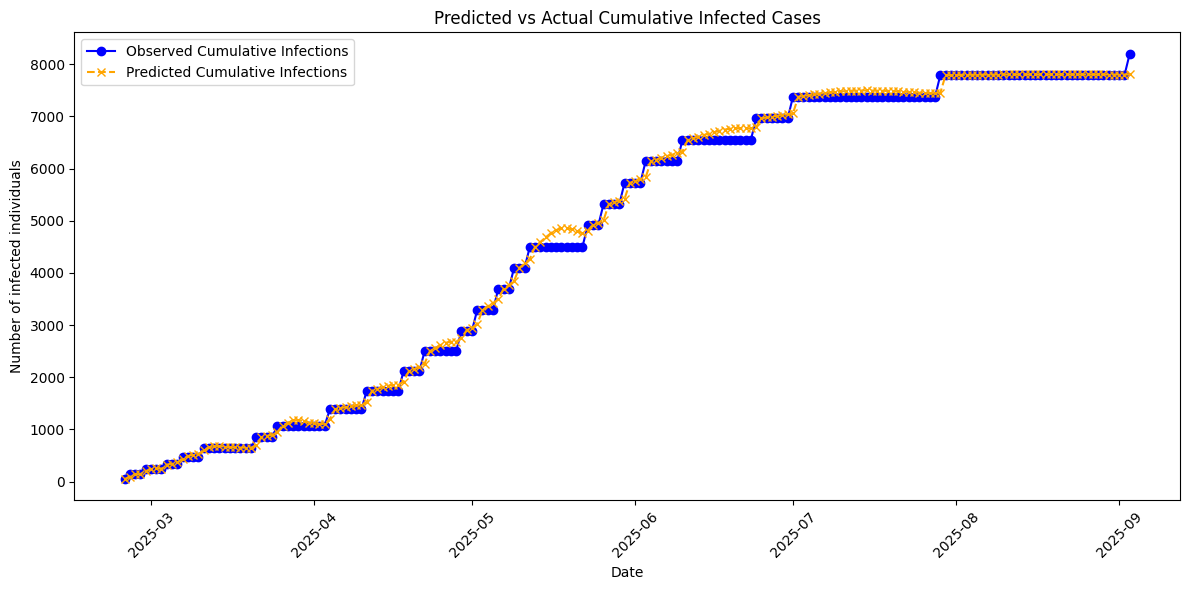

In [74]:
predicted_C = np.nanmean(ensemble_states_hist[:, :, 4], axis=1)  # mean over ensembles for each day
actual_C = merged_df['Cumulative Infected'].to_numpy()

dates = merged_df['date']

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_C, 'o-', label='Observed Cumulative Infections', color='blue')
plt.plot(dates, predicted_C, 'x--', label='Predicted Cumulative Infections', color='orange')
plt.xlabel("Date")
plt.ylabel("Number of infected individuals")
plt.title("Predicted vs Actual Cumulative Infected Cases")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# roll over testing

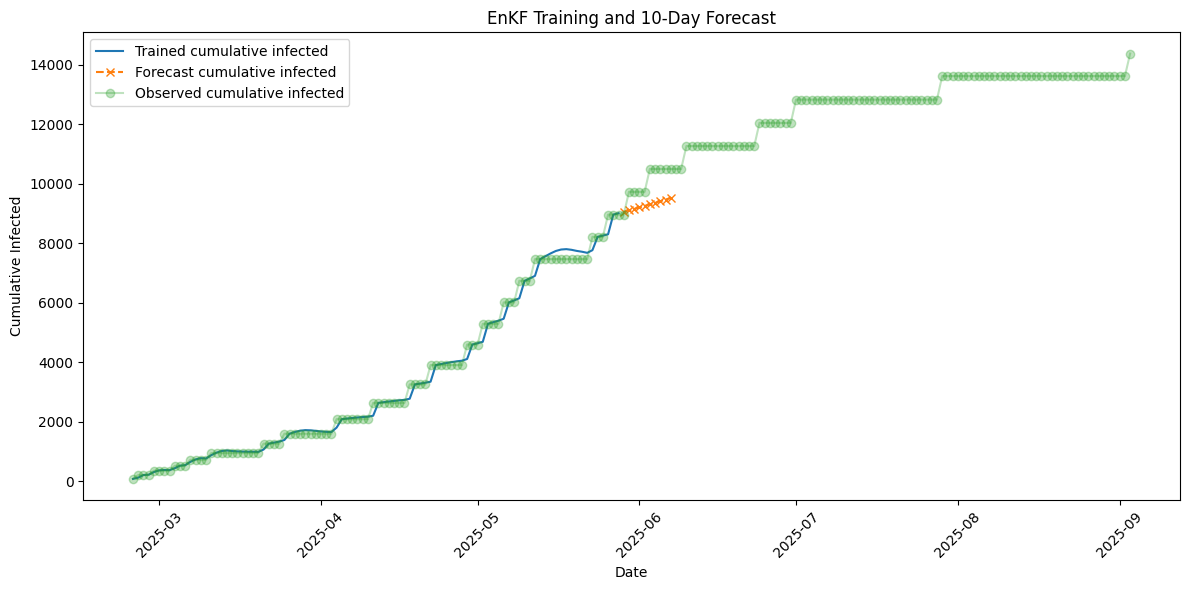

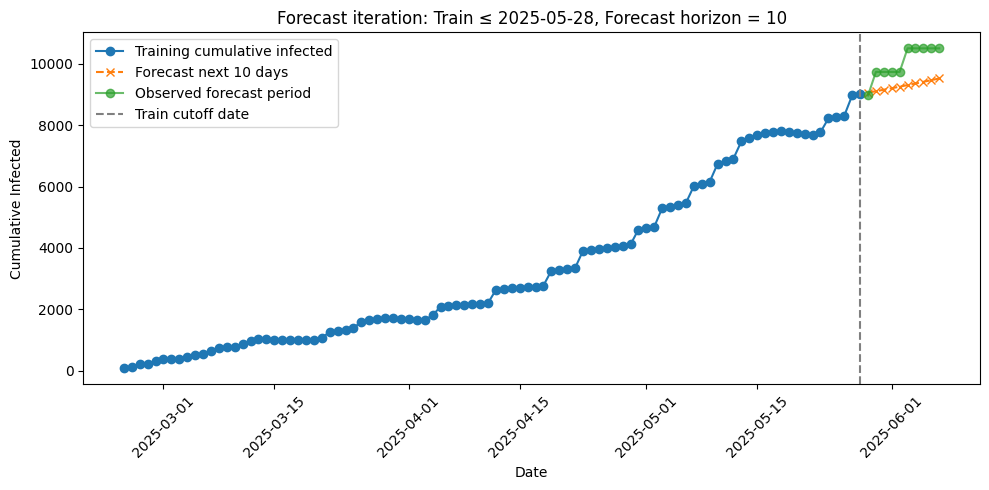

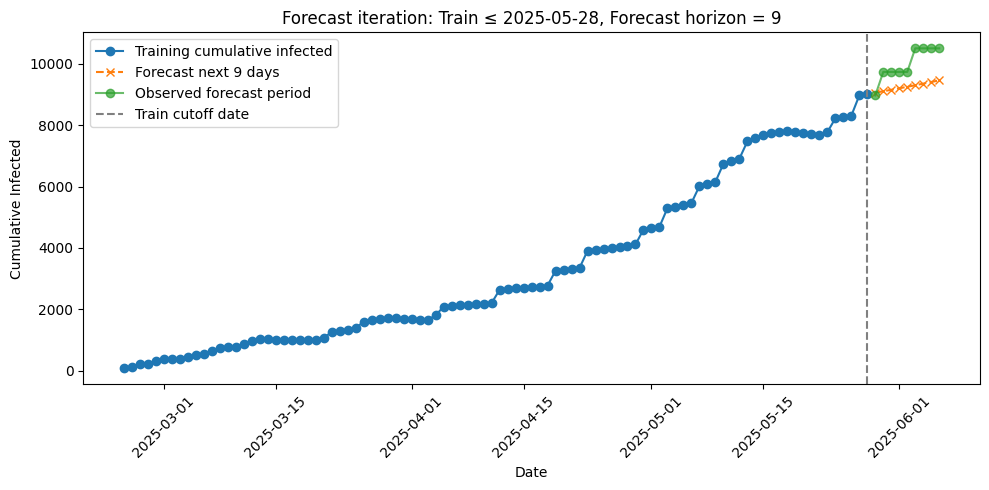

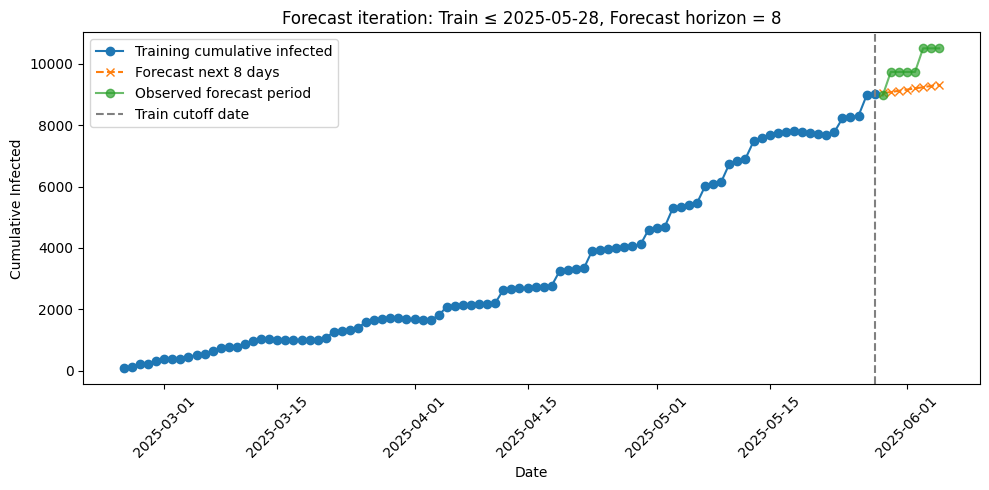

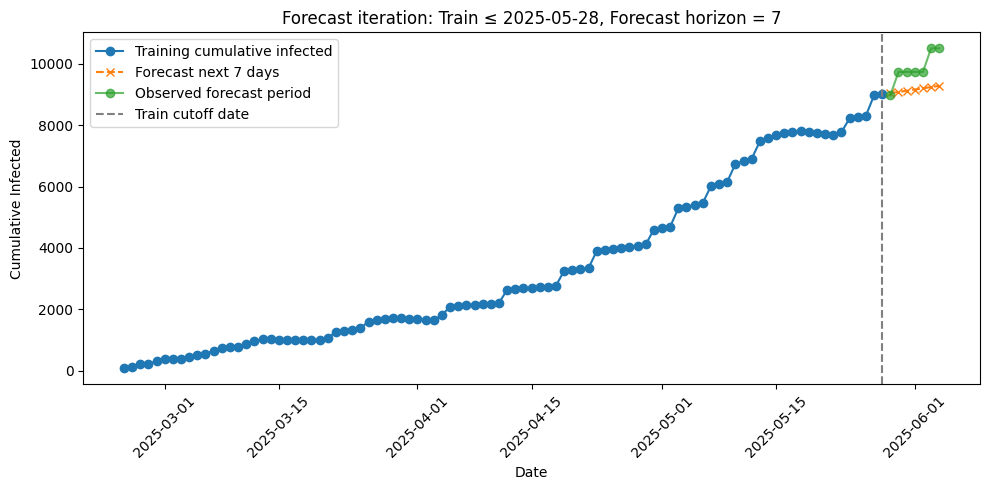

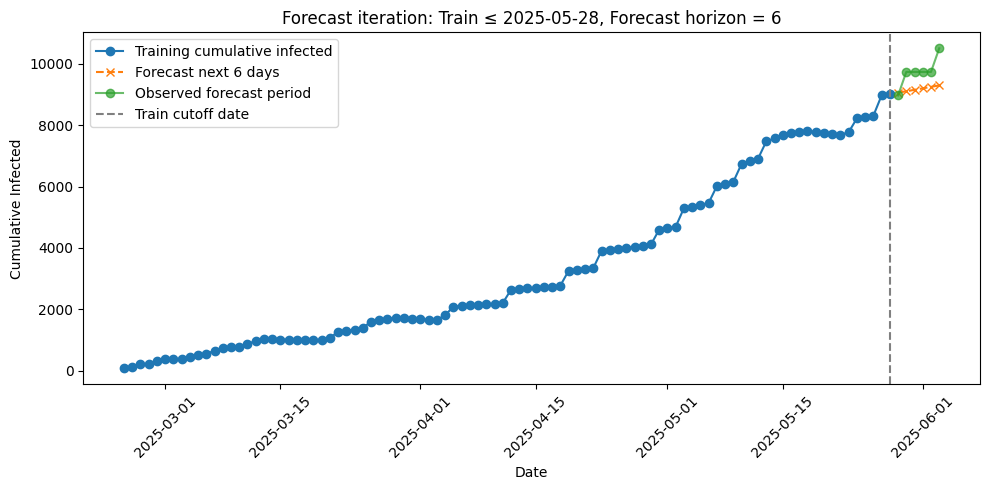

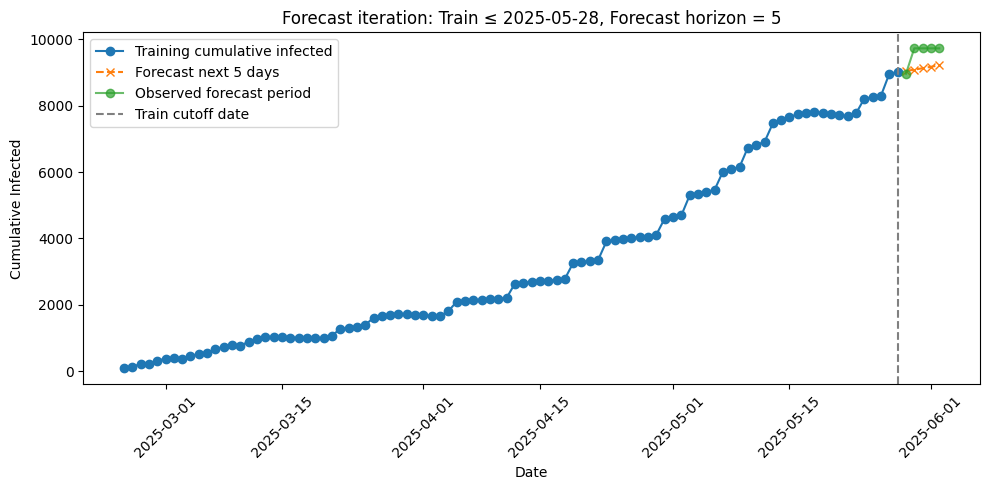

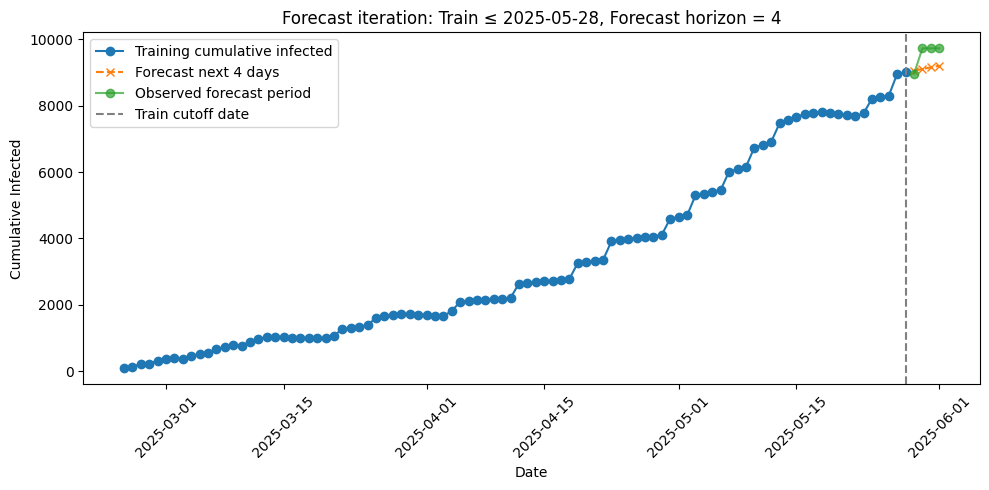

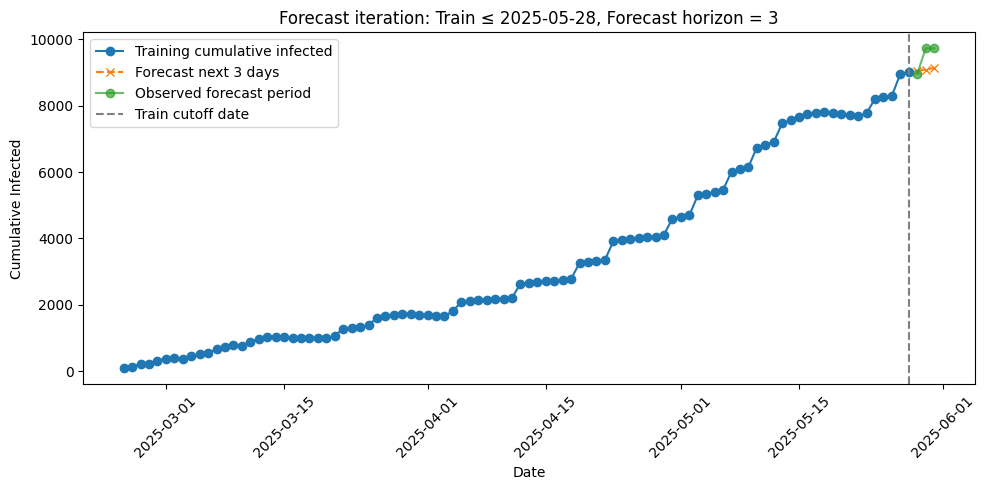

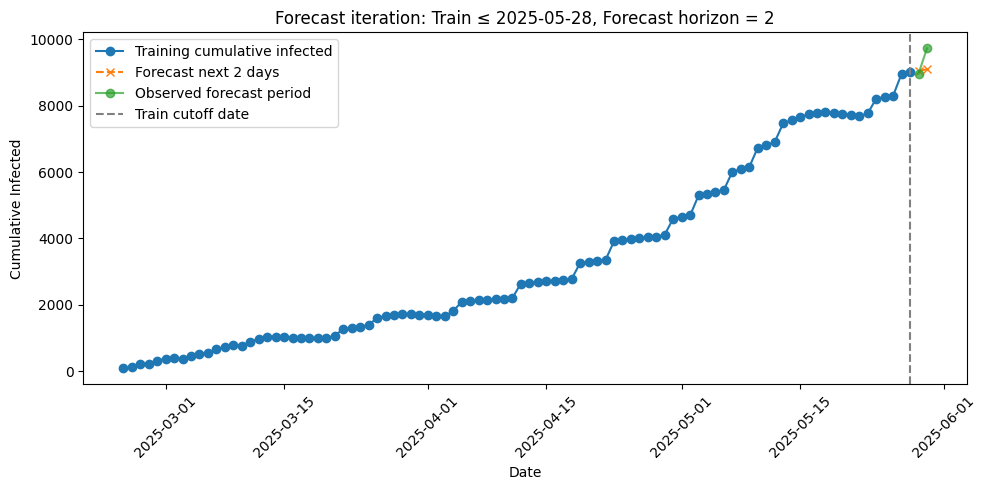

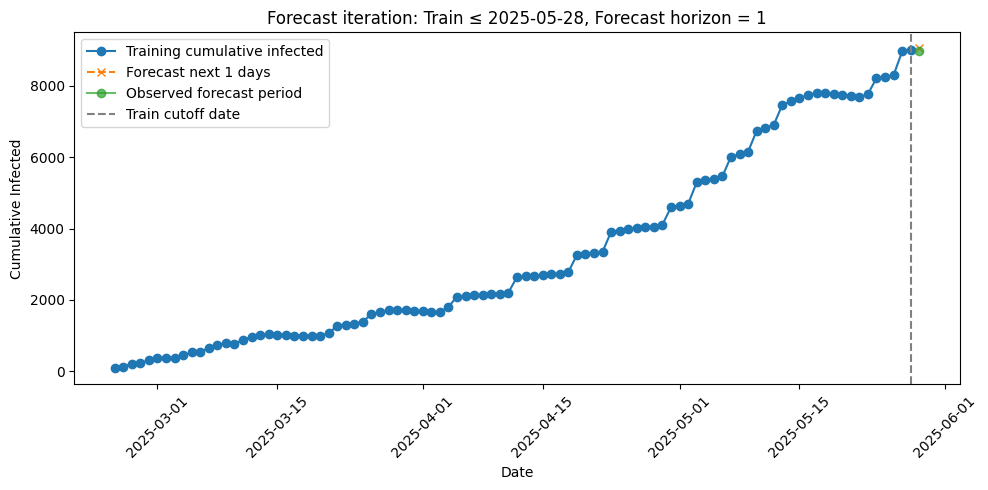

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming all your previous code and functions are already defined:
# sird_step_aug, enforce_mass, predict_measurement, R_from_obs, x0_mean, n_ens, dt, N, alpha, ens_perturb, merged_df, etc.

def run_enkf_train_then_forecast(Y_obs, cap_idx, horizon, sim_seed):
    rng = np.random.default_rng(sim_seed)

    # Initialize ensemble from priors
    state_ens = np.zeros((n_ens, 8))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0)
        S = max(N - IRD.sum(), 0)
        beta = rng.uniform(0.1, 0.9)
        gamma = rng.uniform(0.1, 0.9)
        delta = rng.uniform(0.0001, 0.001)
        C = x0_mean[4]
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    ensemble_states_hist = np.full((cap_idx + 1, n_ens, 5), np.nan)
    for k in range(cap_idx + 1):
        # propagate
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)

        # assimilate observation
        meas_pred = predict_measurement(state_ens)
        y_obs_k = Y_obs[k]
        Rk = R_from_obs(y_obs_k)
        obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

        aug_ens = state_ens.copy()
        aug_mean = aug_ens.mean(axis=0)
        meas_mean = meas_pred.mean(axis=0)

        X = aug_ens - aug_mean
        Y = meas_pred - meas_mean
        Cxy = (X.T @ Y) / (n_ens - 1)
        Cyy = (Y.T @ Y) / (n_ens - 1)
        Kk = Cxy @ np.linalg.inv(Cyy + Rk)

        for i in range(n_ens):
            innovation = obs_perturbed[i] - meas_pred[i]
            aug_update = aug_ens[i] + alpha * (Kk @ innovation)
            state_ens[i] = aug_update
        state_ens = enforce_mass(state_ens, N)

        if k > 0:
            last_obs_C = Y_obs[k-1, 0]
            state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

        ensemble_states_hist[k] = state_ens[:, :5]

    # forecast horizon steps without assimilation
    forecast_states_hist = np.full((horizon, n_ens, 5), np.nan)
    last_obs_C = Y_obs[cap_idx, 0]
    for h in range(horizon):
        for i in range(n_ens):
            state_ens[i] = sird_step_aug(state_ens[i], N, dt)
        state_ens = enforce_mass(state_ens, N)
        state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)
        forecast_states_hist[h] = state_ens[:, :5]

    # Mean over ensemble
    train_mean_states = np.nanmean(ensemble_states_hist, axis=1)
    forecast_mean_states = np.nanmean(forecast_states_hist, axis=1)
    return train_mean_states, forecast_mean_states


# Prepare data indices and inputs
cap_date_str = '2025-05-25'
cap_date = pd.to_datetime(cap_date_str)
dates = merged_df['date'].to_numpy()
Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()
cap_idx = np.where(dates <= cap_date)[0][-1]

# Run single train-then-forecast for full horizon
horizon = 15
train_states, forecast_states = run_enkf_train_then_forecast(Y_obs, cap_idx, horizon, sim_seed=10)

# Plot training and full forecast
plt.figure(figsize=(12, 6))
plt.plot(dates[:cap_idx+1], train_states[:, 4], label='Trained cumulative infected')
plt.plot(dates[cap_idx+1:cap_idx+1+horizon], forecast_states[:, 4], 'x--', label='Forecast cumulative infected')
plt.plot(merged_df['date'], merged_df['Cumulative Infected'], 'o-', alpha=0.3, label='Observed cumulative infected')
plt.xlabel('Date')
plt.ylabel('Cumulative Infected')
plt.title('EnKF Training and 10-Day Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot each prediction iteration with decreasing horizon (10, 9, ..., 1)
for step_ahead in range(horizon):
    this_horizon = horizon - step_ahead
    # reuse same train end index; forecast shorter horizon
    
    _, forecast_short = run_enkf_train_then_forecast(Y_obs, cap_idx, this_horizon, sim_seed=10)

    forecast_dates = pd.date_range(start=cap_date + pd.Timedelta(days=1), periods=this_horizon)
    train_dates = dates[:cap_idx+1]

    plt.figure(figsize=(10, 5))
    plt.plot(train_dates, train_states[:, 4], 'o-', label='Training cumulative infected')
    plt.plot(forecast_dates, forecast_short[:, 4], 'x--', label=f'Forecast next {this_horizon} days')
    
    # Actual observed for forecast period (if available)
    actual_series = merged_df.set_index('date')['Cumulative Infected']
    obs_vals = actual_series.reindex(forecast_dates).values
    mask = ~np.isnan(obs_vals)
    if mask.any():
        plt.plot(forecast_dates[mask], obs_vals[mask], 'o-', alpha=0.7, label='Observed forecast period')

    plt.axvline(cap_date, color='gray', linestyle='--', label='Train cutoff date')
    plt.title(f'Forecast iteration: Train ≤ {cap_date_str}, Forecast horizon = {this_horizon}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Infected')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# infection true data plots

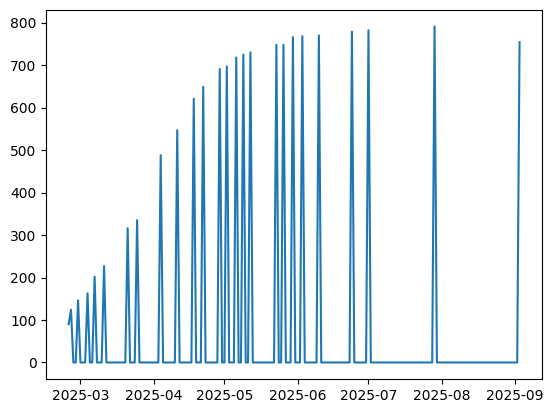

In [ ]:
df = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\infection_county_cases.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

plt.plot(df.index, df['Texas'])

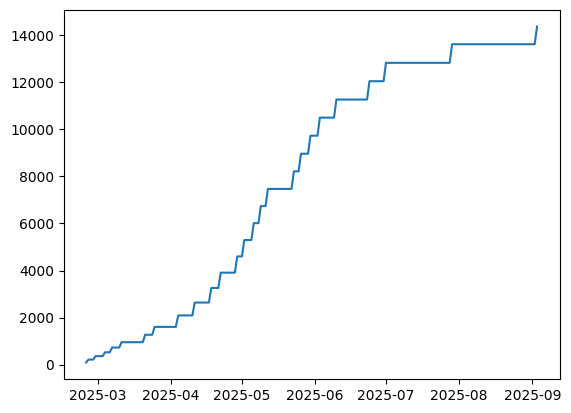

In [ ]:
df = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_infection_county_cases.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

plt.plot(df.index, df['Texas'])